In [1]:
import warnings
warnings.filterwarnings('ignore')
from data_loading import Embeddings, load_sim_dataset, load_analogy_dataset
from clustering import cluster_words, print_cluster_words, visualize_pca
import numpy as np
from scipy.stats import pearsonr, spearmanr
import random

# Evaluating Word Representations

## Word similarity

We will examine the use of word embeddings as representations for the meaning of words. In particular, we will use pretrained word embeddings as obtained in [1]: Dependency based embeddings and bag-of-words embeddings with k = 2 and 5.

In [2]:
# Load word embeddings
bow2embeddings = Embeddings("data/bow2.words")
bow5embeddings = Embeddings("data/bow5.words")
depembeddings = Embeddings("data/deps.words")
embedding_dict = {'BOW2': bow2embeddings, 'BOW5': bow5embeddings, 'Dependency': depembeddings}

# Load similarity datasets
simlex_pairs, simlex_scores = load_sim_dataset("data/SimLex-999.txt", score_col=3, skip=1)
men_pairs, men_scores = load_sim_dataset("data/MEN_dataset_natural_form_full", score_col=2)

### Qualitative results
We can evaluate the word embeddings quantitatively by getting a list of words similar to a given one when using each set of word embeddings.

In [3]:
test_words = ['batman', 'hogwarts', 'turing', 'florida', 'object-oriented', 'dancing']
for emb in embedding_dict:
    print(emb)
    for word in test_words:
        print('\t', word, ':', embedding_dict[emb].top_similar(word))

### Quantitative results

In [4]:
def score_pairs(pairs, scores, embs, label):
    gold_scores = []
    sim_scores = []
    for i, (word1, word2) in enumerate(pairs):
        if word1 in embs.word2idx and word2 in embs.word2idx:
            # Get score from gold standard
            gold_scores.append(scores[i])
            
            # Calculate cosine similarity
            sim_scores.append(embs.similarity(word1, word2))
            
    # Get pearson and spearman correlation
    pearson_coeff = pearsonr(gold_scores, sim_scores)[0]
    spearman_coeff = spearmanr(gold_scores, sim_scores).correlation
    
    print('{:>10} {:^8.4f}  {:^8.4f}'.format(label, pearson_coeff, spearman_coeff))

print('{:10} {:^8s}  {:^8s}'.format('', 'Pearson', 'Spearman'))
for emb_name in embedding_dict:
    print('{:s}'.format(emb_name))    
    score_pairs(simlex_pairs, simlex_scores, embedding_dict[emb_name], 'SimLEX')    
    score_pairs(men_pairs, men_scores, embedding_dict[emb_name], 'MEN')

## Word Analogy

We now examine the usage of word embeddings to solve questions of the form "**a** is to **b** as **c** is to **?**".

### Qualitative results

In [5]:
answers = bow5embeddings.analogy('man', 'king', 'woman')
print(answers[:5])

### Quantitative results

In [6]:
analogies = load_analogy_dataset('data/questions-words.txt')

def get_analogy_stats(embs, analogies):
    count = 0
    correct = 0
    acc_rank = 0
    for i, (a, b, c, d) in enumerate(analogies):
        # Check first if we have embeddings for all words
        if all (word in embs.word2idx for word in (a, b, c)):
            count += 1
            # Get analogy results
            results = embs.analogy(a, b, c)

            # Update accuracy
            if results[0] == d:
                correct += 1

            # Update MRR
            try:            
                rank = results.index(d) + 1            
                acc_rank += 1/rank          
            except ValueError:
                # If word was not ranked, give rank score = 0
                continue
        
        # Print progress and stats so far
        if (count%1000) == 0:
            accuracy = int(100 * correct/count)
            mrr = int(100 * acc_rank/count)
            print('{:d}/{:d} acc: {:d} mrr: {:d}'.format(count, len(analogies), accuracy, mrr))

    accuracy = int(100 * correct/count)
    mrr = int(100 * acc_rank/count)
    print('acc: {:d} mrr: {:d}'.format(accuracy, mrr))

for emb_name in embedding_dict:
    print('{:s}'.format(emb_name))
    get_analogy_stats(embedding_dict[emb_name], analogies)

## Clustering word vectors

We now cluster the given 2000 frequent nouns by apply K-means clustering to each of the three word embedding models. We experiment with 5 different cluster sizes = {10,25,50,100,200} and analyze the qualitative properties of the clustered words for each of the three word embedding models.

In [7]:
frequent_nouns = []
with open('data/2000_nouns_sorted.txt','r') as f:
    for line in f:
        for word in line.split():
            if word != 'fig.':
               frequent_nouns.append(word)
        
num_clusters=10        
frequent_embeddings, bow2_labels, bow5_labels, dep_labels = cluster_words(embedding_dict, frequent_nouns, num_clusters)

print("Number of clusters = {}".format(num_clusters))
cluster_num = random.randint(1, num_clusters)

print("Words clusterd with bow2 embeddings in cluster {}: ".format(cluster_num))
print_cluster_words(cluster_num, frequent_nouns, bow2_labels)
        
print("Words clusterd with bow5 embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, bow5_labels)

print("Words clusterd with dep embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, dep_labels) 

Number of clusters = 10
Words clusterd with bow2 embeddings in cluster 4: 
['acre', 'africa', 'airport', 'alliance', 'america', 'american', 'apartment', 'april', 'area', 'army', 'assembly']
Words clusterd with bow5 embeddings in cluster 4: 
['alarm', 'ankle', 'apple', 'arrow', 'baby', 'ball', 'barrel', 'basket', 'bathroom', 'beam', 'bedroom']
Words clusterd with dep embeddings in cluster 4: 
['dollar', 'pound', 'accommodation', 'advertising', 'alcohol', 'allowance', 'asset', 'beer', 'bond', 'bread', 'breakfast']


In [8]:
num_clusters=25
frequent_embeddings, bow2_labels, bow5_labels, dep_labels = cluster_words(embedding_dict, frequent_nouns, num_clusters)

print("Number of clusters = {}".format(num_clusters))
cluster_num = random.randint(1, num_clusters)

print("Words clusterd with bow2 embeddings in cluster {}: ".format(cluster_num))
print_cluster_words(cluster_num, frequent_nouns, bow2_labels)
        
print("Words clusterd with bow5 embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, bow5_labels)

print("Words clusterd with dep embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, dep_labels)

visual_embeddings = frequent_embeddings
v_bow2_labels = bow2_labels 
v_bow5_labels = bow5_labels 
v_dep_labels = dep_labels

Number of clusters = 25
Words clusterd with bow2 embeddings in cluster 22: 
['attempt', 'back', 'block', 'blow', 'break', 'breath', 'call', 'chance', 'change', 'check', 'contact']
Words clusterd with bow5 embeddings in cluster 22: 
['ambition', 'angel', 'anger', 'anxiety', 'attitude', 'beauty', 'belief', 'breath', 'chaos', 'christ', 'conception']
Words clusterd with dep embeddings in cluster 22: 
['barrier', 'bathroom', 'bedroom', 'bench', 'ceiling', 'cupboard', 'curtain', 'deck', 'desk', 'door', 'doorway']


In [9]:
num_clusters=50
frequent_embeddings, bow2_labels, bow5_labels, dep_labels = cluster_words(embedding_dict, frequent_nouns, num_clusters)

print("Number of clusters = {}".format(num_clusters))
cluster_num = random.randint(1, num_clusters)

print("Words clusterd with bow2 embeddings in cluster {}: ".format(cluster_num))
print_cluster_words(cluster_num, frequent_nouns, bow2_labels)
        
print("Words clusterd with bow5 embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, bow5_labels)

print("Words clusterd with dep embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, dep_labels)

Number of clusters = 50
Words clusterd with bow2 embeddings in cluster 45: 
['alcohol', 'apple', 'beer', 'bottle', 'bread', 'breakfast', 'cake', 'champagne', 'cigarette', 'coffee', 'cream']
Words clusterd with bow5 embeddings in cluster 45: 
['acid', 'addition', 'array', 'aspect', 'characteristic', 'cluster', 'combination', 'complex', 'component', 'compound', 'core']
Words clusterd with dep embeddings in cluster 45: 
['amount', 'array', 'average', 'bulk', 'combination', 'couple', 'excess', 'fraction', 'handful', 'majority', 'maximum']


In [10]:
num_clusters=100
frequent_embeddings, bow2_labels, bow5_labels, dep_labels = cluster_words(embedding_dict, frequent_nouns, num_clusters)

print("Number of clusters = {}".format(num_clusters))
cluster_num = random.randint(1, num_clusters)

print("Words clusterd with bow2 embeddings in cluster {}: ".format(cluster_num))
print_cluster_words(cluster_num, frequent_nouns, bow2_labels)
        
print("Words clusterd with bow5 embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, bow5_labels)

print("Words clusterd with dep embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, dep_labels)

Number of clusters = 100
Words clusterd with bow2 embeddings in cluster 45: 
['angle', 'barrel', 'beam', 'camera', 'chip', 'circuit', 'field', 'forward', 'frequency', 'impulse', 'lamp']
Words clusterd with bow5 embeddings in cluster 45: 
['barrier', 'bridge', 'circle', 'circuit', 'corner', 'edge', 'entrance', 'gate', 'lane', 'ring', 'road']
Words clusterd with dep embeddings in cluster 45: 
['accountant', 'architect', 'doctor', 'engineer', 'expert', 'historian', 'lawyer', 'practitioner', 'researcher', 'scholar', 'scientist']


In [11]:
num_clusters=200
frequent_embeddings, bow2_labels, bow5_labels, dep_labels = cluster_words(embedding_dict, frequent_nouns, num_clusters)

print("Number of clusters = {}".format(num_clusters))
cluster_num = random.randint(1, num_clusters)

print("Words clusterd with bow2 embeddings in cluster {}: ".format(cluster_num))
print_cluster_words(cluster_num, frequent_nouns, bow2_labels)
        
print("Words clusterd with bow5 embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, bow5_labels)

print("Words clusterd with dep embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, dep_labels)

Number of clusters = 200
Words clusterd with bow2 embeddings in cluster 24: 
['formula', 'account', 'calculation', 'curve', 'datum', 'equation', 'estimate', 'formula', 'index', 'measure', 'measurement']
Words clusterd with bow5 embeddings in cluster 24: 
['approval', 'consent', 'consultation', 'permission', 'sanction', 'seal']
Words clusterd with dep embeddings in cluster 24: 
['author', 'critic', 'historian', 'journalist', 'lawyer', 'poet', 'politician', 'researcher', 'scholar', 'scientist', 'writer']


### Visualizing the word vectors

Next we use PCA to visualize the word vectors(of the 3 representations) in 2 dimension to understand relation between the words that are close together. We use the labels from the results of clustering with size=25, so we get a good separation between words. Also we pick 200 words from the 2000 words to visualize for brevity.

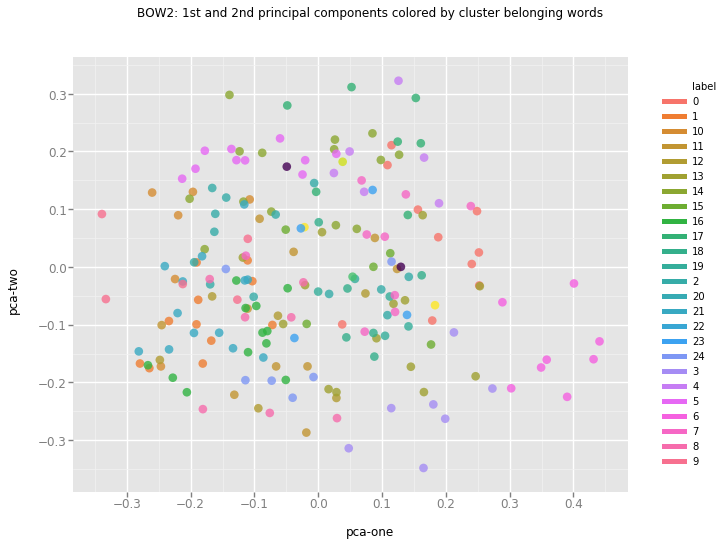

<ggplot: (282464232)>


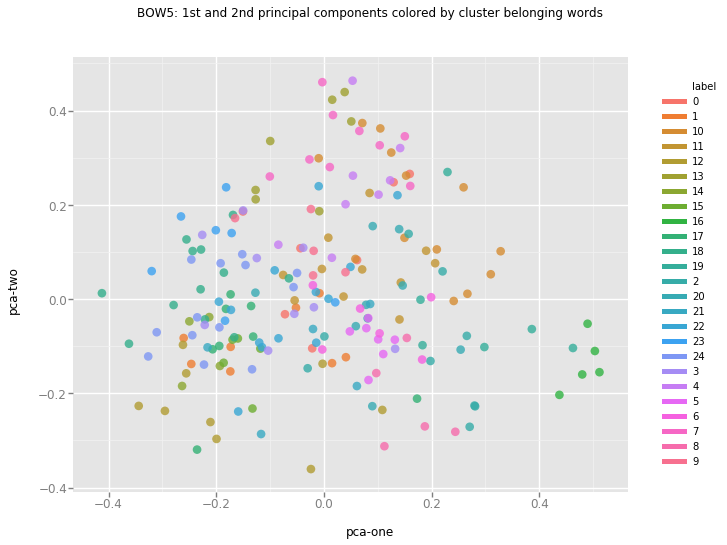

<ggplot: (-9223372036514968397)>


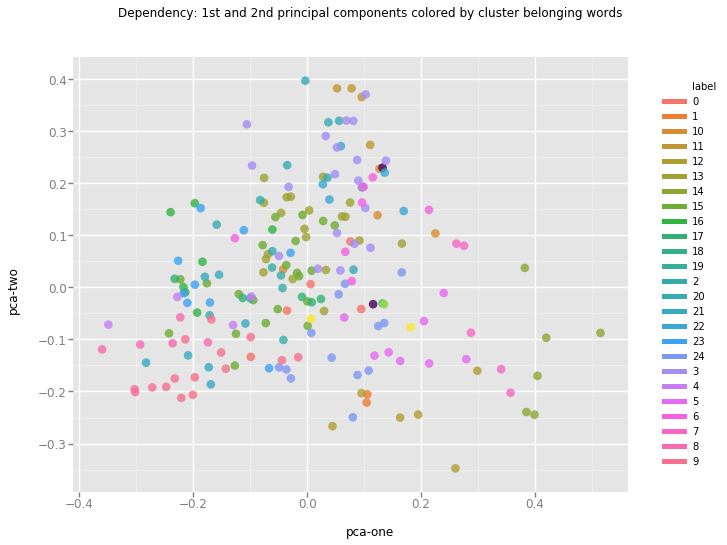

<ggplot: (-9223372036574197076)>


In [12]:
visualize_pca(visual_embeddings['BOW2'], v_bow2_labels, emb_type="BOW2")
visualize_pca(visual_embeddings['BOW5'], v_bow5_labels, emb_type="BOW5")
visualize_pca(visual_embeddings['Dependency'], v_dep_labels, emb_type="Dependency") 

### References
[1] Levy, O., & Goldberg, Y. (2014). Dependency-based word embeddings. In Proceedings of the 52nd Annual Meeting of the Association for Computational Linguistics (Volume 2: Short Papers) (Vol. 2, pp. 302-308).